# Euclidean space

* Load original embeddings
* Euclidean MDS

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.linalg import orthogonal_procrustes
import statsmodels.api as sm
import scipy.stats as stats
from hyperbolicMDS.mds import HyperMDS, cart_to_polar
from matplotlib import colors
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
import re, seaborn as sns
from sklearn.manifold import MDS
from scipy import stats
from scipy.spatial import distance_matrix

data_dir = '../data'
output_dir = '../outputs'

In [2]:
input_distance_matrix = pd.read_csv(os.path.join(data_dir, 'coef_embed.csv'), header=None).to_numpy()
input_distance_matrix.shape

(49, 49)

In [3]:
embedding = MDS(n_components=16)
transformed_dist = embedding.fit_transform(input_distance_matrix)
# eu_dist = np.corrcoef(transformed_dist, rowvar=True)
# eu_dist = 1 - abs(eu_dist)
eu_dist = distance_matrix(transformed_dist, transformed_dist)

stats.spearmanr(eu_dist.flatten(),input_distance_matrix.flatten()) 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


SpearmanrResult(correlation=0.5368060707737525, pvalue=2.5926090240511806e-179)

In [4]:
# load original 1854*49 embeddings
original_embeddings = np.loadtxt(os.path.join(data_dir, 'spose_embedding_49d_sorted.txt'))
original_embeddings.shape

(1854, 49)

In [5]:
# load categories and memorability score of each concept
cat_mapping = pd.read_csv(os.path.join(data_dir, 'THINGS_Table.csv'))
cat_concept_mem = cat_mapping[['cr', 'smallcat', 'bigcat']].groupby('smallcat').mean()
cat_concept_mem['bigcat'] = cat_concept_mem['bigcat'].astype(int).replace(0, 99)
cat_concept_mem

,cr,bigcat
smallcat,,
1,0.779739,1
2,0.798485,13
3,0.752845,18
4,0.761851,99
5,0.794466,9
...,...,...
1850,0.722655,99
1851,0.843158,10
1852,0.800163,1


In [6]:
### load category names and merge with concepts
cat = loadmat(os.path.join(data_dir,'categories.mat'))
cat_names = [item[0] for item in cat['categories'][0]]
cat_names.append('na')
cat_names = pd.DataFrame(cat_names, columns=['cat_name']).reset_index()
cat_names['index'] = cat_names['index']+1
cat_names.iloc[27] = [99, np.nan]
cat_concept_mem = cat_concept_mem.merge(cat_names, how='left', left_on='bigcat', right_on='index').drop(columns=['index'])
cat_concept_mem


,cr,bigcat,cat_name
0,0.779739,1,animal
1,0.798485,13,home decor
2,0.752845,18,musical instrument
3,0.761851,99,NaN
4,0.794466,9,electronic device
...,...,...,...
1849,0.722655,99,NaN
1850,0.843158,10,food
1851,0.800163,1,animal
1852,0.797468,99,NaN


# Analysis

1. Analysis: predicting memorability (euclidean vs. mobius)
    * Cartesian coordinates (x, y, z: which axis explains variances in memorability the best)
    * Polar coordinates (r, theta, rho: which angle explains the best)
    * Radius (concepts closer to the core vs. on surface are more memorable?)
    * K-Means clusters:
      - Cartesian coordinates
      - Polar coordinates
2. Analysis: with typicality (euclidean vs. mobius)
    * Calculate typicality: average similarity of each concept pair within category 
    * Predicting typicality
      - Cartesian coordinates
      - Polar coordinates 
      - Radius
    * Predicting memorability
      - Typicality (more prototypical --> more memorable?)
      - Typicality + coordinates/radius to predict memorability
        


In [7]:
### normalize embeddings and transform concept embeddings to loadings in feature space
normalized_embeddings = (original_embeddings.T/np.sqrt((original_embeddings**2).sum(axis=1))).T
concept_in_feat_coord = normalized_embeddings@transformed_dist
#     concept_in_feat_coord.append(mobius_addition(normalized_embeddings, feature_embeddings[:,:,layer], 48))
np.array(concept_in_feat_coord).shape

(1854, 16)

In [8]:
### merge concept loadings with category and memorability
mean_concept_in_feat_cat = pd.DataFrame(concept_in_feat_coord).reset_index().merge(cat_concept_mem, how='left', left_on='index', right_index=True)
mean_concept_in_feat_cat_na = mean_concept_in_feat_cat.dropna()
mean_concept_in_feat_cat_na

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,cr,bigcat,cat_name
0,0,0.077886,-0.224408,-0.114841,-0.477426,-0.307127,-0.167953,0.068738,-0.063158,-0.130403,-0.153406,-0.736540,-0.083639,-0.055920,0.033751,-0.201222,0.138845,0.779739,1,animal
1,1,-0.333449,-0.285634,0.277407,-0.032578,0.047640,-0.187553,-0.033501,-0.137029,-0.288971,0.053209,-0.371951,-0.068251,-0.326356,-0.026059,0.287328,0.115957,0.798485,13,home decor
2,2,-0.403785,-0.121386,0.466893,-0.021158,-0.158123,0.074964,-0.077174,0.155455,-0.529358,-0.161019,-0.206382,0.169740,-0.562778,-0.128516,0.153146,0.207903,0.752845,18,musical instrument
4,4,0.095493,0.125046,0.053150,-0.325220,-0.294549,-0.215565,0.046874,-0.263060,-0.548106,0.161183,-0.273101,0.015367,-0.460362,0.205768,-0.046408,0.019230,0.794466,9,electronic device
5,5,0.066749,0.128649,0.122151,0.029590,-0.234311,-0.230952,0.040841,-0.195369,-0.139756,0.176787,-0.233855,0.037075,-0.395695,0.273942,-0.007227,-0.089091,0.806000,12,furniture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,0.055852,-0.064933,0.281485,-0.020498,-0.031083,-0.149631,0.502474,0.069013,-0.028106,-0.048294,0.056968,-0.118383,0.249460,-0.261545,0.211566,0.068391,0.803129,24,toy
1848,1848,0.057545,-0.268397,0.048472,0.155653,-0.192519,-0.168728,0.297230,-0.042202,-0.257999,-0.227907,-0.321192,-0.122898,0.024213,0.635877,-0.210706,0.315289,0.765881,10,food
1850,1850,0.084543,-0.182174,0.046293,0.031827,-0.093121,-0.198181,0.259117,-0.313850,-0.335454,-0.219567,-0.309781,-0.210304,0.036511,0.500188,-0.124295,0.328433,0.843158,10,food
1851,1851,0.085708,-0.221763,-0.208360,-0.410933,-0.386940,-0.205366,-0.073309,-0.123420,-0.142344,-0.181796,-0.604574,-0.021480,-0.107778,-0.107017,-0.203984,0.011917,0.800163,1,animal


### Cartesian

In [9]:
coordinates = mean_concept_in_feat_cat.loc[:, 0:15]
coordinates

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.077886,-0.224408,-0.114841,-0.477426,-0.307127,-0.167953,0.068738,-0.063158,-0.130403,-0.153406,-0.736540,-0.083639,-0.055920,0.033751,-0.201222,0.138845
1,-0.333449,-0.285634,0.277407,-0.032578,0.047640,-0.187553,-0.033501,-0.137029,-0.288971,0.053209,-0.371951,-0.068251,-0.326356,-0.026059,0.287328,0.115957
2,-0.403785,-0.121386,0.466893,-0.021158,-0.158123,0.074964,-0.077174,0.155455,-0.529358,-0.161019,-0.206382,0.169740,-0.562778,-0.128516,0.153146,0.207903
3,-0.151608,-0.239816,0.221118,0.079321,-0.112052,-0.024827,0.085815,-0.264990,-0.292707,-0.257386,-0.416188,-0.269202,-0.161197,0.508530,0.386125,0.115589
4,0.095493,0.125046,0.053150,-0.325220,-0.294549,-0.215565,0.046874,-0.263060,-0.548106,0.161183,-0.273101,0.015367,-0.460362,0.205768,-0.046408,0.019230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,-0.427972,-0.383988,0.354051,-0.108097,0.016349,-0.248061,-0.061059,0.025821,-0.254519,-0.065487,-0.595150,-0.254990,-0.350523,0.436402,0.002986,0.154688
1850,0.084543,-0.182174,0.046293,0.031827,-0.093121,-0.198181,0.259117,-0.313850,-0.335454,-0.219567,-0.309781,-0.210304,0.036511,0.500188,-0.124295,0.328433
1851,0.085708,-0.221763,-0.208360,-0.410933,-0.386940,-0.205366,-0.073309,-0.123420,-0.142344,-0.181796,-0.604574,-0.021480,-0.107778,-0.107017,-0.203984,0.011917
1852,-0.042473,0.127755,0.375298,-0.126698,-0.183260,-0.188876,0.076415,0.047684,-0.074348,-0.024202,-0.534675,-0.022504,-0.295683,0.536654,-0.035133,0.288253


In [10]:
### linreg: cartesian coordinates and z-score memorability
# Euclidean: R^2 = 0.271, adjusted = 0.265
import statsmodels.api as sm
import scipy.stats as stats

zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(coordinates, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     47.03
Date:                Sun, 11 Sep 2022   Prob (F-statistic):          2.27e-124
Time:                        19:11:32   Log-Likelihood:                -2312.5
No. Observations:                1854   AIC:                             4659.
Df Residuals:                    1837   BIC:                             4753.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.0287      0.110      9.318      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### Polar coordinates

In [11]:
# ### Polar coordinates of concepts in hyperbolic feature space
# r, theta, rho = cart_to_polar(coordinates.values).T
# plt.hist2d(theta, rho,
#            bins = 20)

### Radius
small R^2, with concepts closer to the core/origin being more memorable

<IPython.core.display.Javascript object>


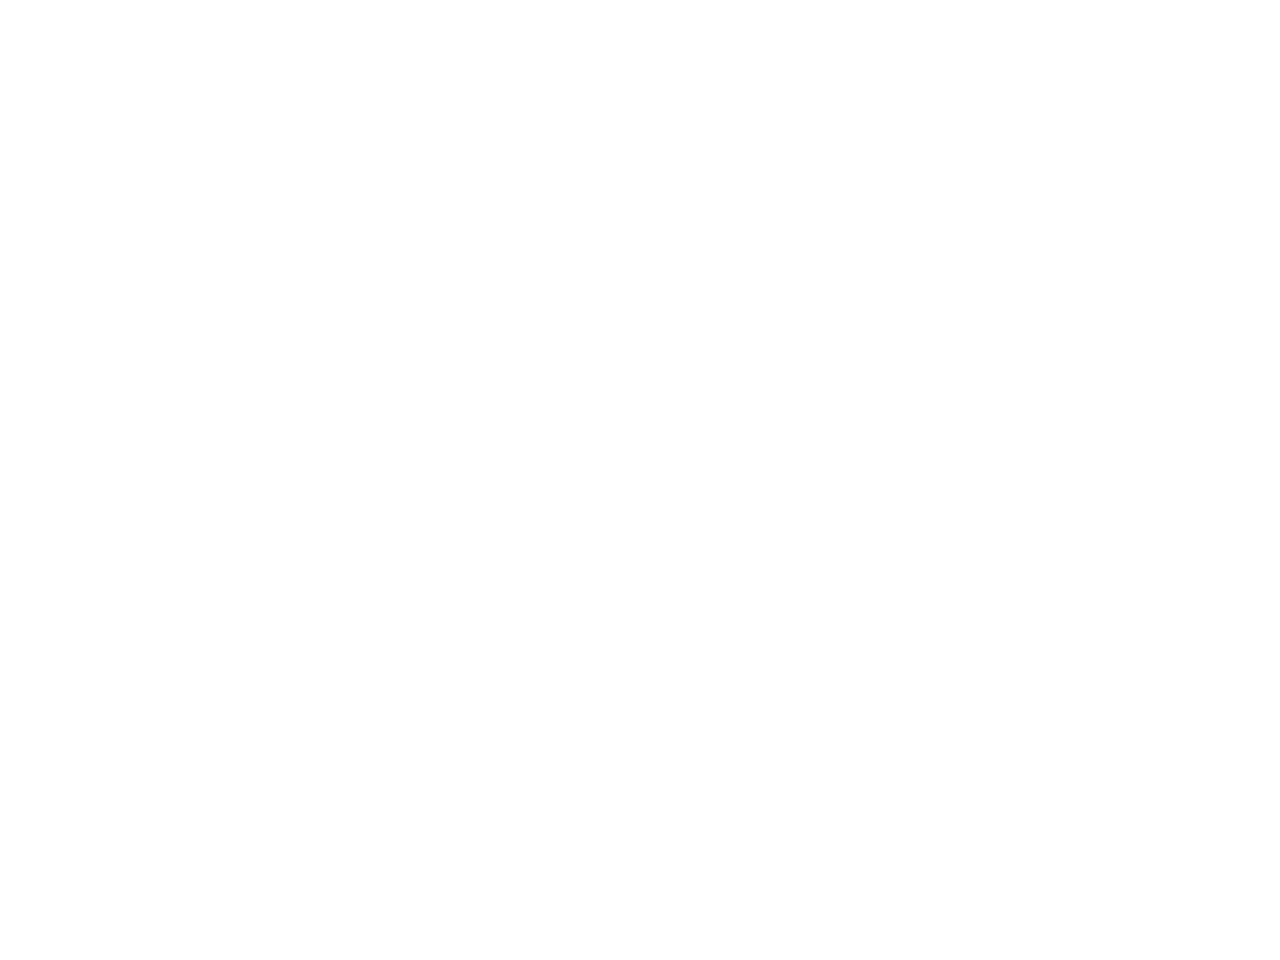

(array([  3.,  17.,  72., 212., 396., 493., 355., 211.,  81.,  14.]),
 array([0.51080134, 0.60644383, 0.70208632, 0.79772881, 0.8933713 ,
        0.9890138 , 1.08465629, 1.18029878, 1.27594127, 1.37158376,
        1.46722626]),
 <BarContainer object of 10 artists>)

In [12]:
### Radius
%matplotlib notebook
import matplotlib.pyplot as plt
concept_radius_in_feat = np.sqrt((coordinates**2).sum(1))

plt.clf()
plt.hist(concept_radius_in_feat)

In [13]:
### Radius vs. memorability
# Euclidean: R^2 = 0.006, adjsuted = 0.005
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_radius_const = sm.add_constant(concept_radius_in_feat, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_radius_const)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.120
Date:                Sun, 11 Sep 2022   Prob (F-statistic):            0.00769
Time:                        19:11:32   Log-Likelihood:                -2627.2
No. Observations:                1854   AIC:                             5258.
Df Residuals:                    1852   BIC:                             5269.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.4284      0.161     -2.668      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### KMeans

In [14]:
import math

inertia = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(coordinates)
#     print(kmeans.inertia_)
    inertia.append(kmeans.inertia_)
print(inertia)

[1412.22029937215, 1206.8593337415198, 1090.3886671244393, 1002.5777173686868, 930.4653579582229, 878.4563215722519, 835.5629578365492, 799.7408287887323, 771.4193847951302, 750.5085870904583, 730.6608086111572, 712.1011689227938, 700.9621845511815, 684.5996180271705]


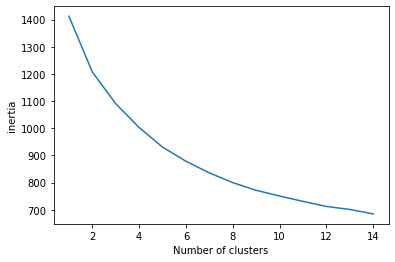

In [15]:
%matplotlib inline
plt.plot(range(1, 15), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('inertia') 
plt.show()
    

In [16]:
### K-Means clustering on concepts
kmeans = KMeans(n_clusters=4, random_state=42).fit(coordinates)
labels = kmeans.labels_
concept_coord_cluster = mean_concept_in_feat_cat
concept_coord_cluster['label'] = labels
kmeans.cluster_centers_


array([[-0.08267553, -0.15762542,  0.13976736,  0.11004745, -0.10284628,
        -0.15931151,  0.08068507, -0.12924037, -0.3317072 , -0.14802574,
        -0.34475321,  0.02601958, -0.09382128,  0.40107642, -0.16557877,
         0.18383083],
       [-0.33800178, -0.11958718,  0.23682761, -0.07775419, -0.00401342,
        -0.10999702,  0.04514792,  0.13289419, -0.34327171, -0.08664725,
        -0.404803  , -0.18362836, -0.18504982,  0.15325273,  0.02656962,
         0.27251622],
       [ 0.0135589 , -0.04716086,  0.01000627, -0.23836854, -0.11321963,
        -0.16833458, -0.00481716, -0.13501163, -0.0737118 , -0.04551833,
        -0.46986185,  0.06452611, -0.14317111,  0.07588662,  0.02833304,
         0.07982407],
       [ 0.22350666,  0.23308113,  0.14955813,  0.09800669, -0.05432844,
         0.06668872,  0.09769536,  0.055812  ,  0.29489092, -0.06345574,
        -0.09007796, -0.0849743 , -0.18540069,  0.47331572, -0.03680489,
         0.10397941]])

In [17]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0.loc[:, 0:15], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     18.83
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           1.70e-43
Time:                        19:11:34   Log-Likelihood:                -762.45
No. Observations:                 626   AIC:                             1559.
Df Residuals:                     609   BIC:                             1634.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.9679      0.264      7.461      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [79]:
### cluster 0: radius vs. memorability
radius_cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(radius_cluster_0['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_0.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     54.86
Date:                Mon, 12 Sep 2022   Prob (F-statistic):           4.22e-13
Time:                        00:49:09   Log-Likelihood:                -861.88
No. Observations:                 626   AIC:                             1728.
Df Residuals:                     624   BIC:                             1737.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -2.0788      0.281     -7.407      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [18]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1.loc[:, 0:15], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     7.616
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           8.10e-16
Time:                        19:11:34   Log-Likelihood:                -560.19
No. Observations:                 434   AIC:                             1154.
Df Residuals:                     417   BIC:                             1224.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1861      0.335      0.555      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [80]:
### cluster 1: radius vs. memorability
radius_cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(radius_cluster_1['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_1.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3927
Date:                Mon, 12 Sep 2022   Prob (F-statistic):              0.531
Time:                        00:49:12   Log-Likelihood:                -615.62
No. Observations:                 434   AIC:                             1235.
Df Residuals:                     432   BIC:                             1243.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.2170      0.346      0.627      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [19]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2.loc[:, 0:15], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     4.994
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           1.31e-09
Time:                        19:11:34   Log-Likelihood:                -672.61
No. Observations:                 501   AIC:                             1379.
Df Residuals:                     484   BIC:                             1451.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.7117      0.279      2.549      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [81]:
### cluster 2: radius vs. memorability
radius_cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(radius_cluster_2['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_2.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.01151
Date:                Mon, 12 Sep 2022   Prob (F-statistic):              0.915
Time:                        00:49:14   Log-Likelihood:                -710.88
No. Observations:                 501   AIC:                             1426.
Df Residuals:                     499   BIC:                             1434.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0348      0.324      0.107      0.9

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [20]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3.loc[:, 0:15], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     10.01
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           8.49e-20
Time:                        19:11:34   Log-Likelihood:                -348.70
No. Observations:                 293   AIC:                             731.4
Df Residuals:                     276   BIC:                             794.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.6672      0.289      2.307      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [82]:
### cluster 3: radius vs. memorability
radius_cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(radius_cluster_3['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_3.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     28.34
Date:                Mon, 12 Sep 2022   Prob (F-statistic):           2.04e-07
Time:                        00:49:19   Log-Likelihood:                -402.13
No. Observations:                 293   AIC:                             808.3
Df Residuals:                     291   BIC:                             815.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              2.0315      0.382      5.324      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [83]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.041529369709089825

### Typicality

In [22]:
def calculate_typicality(group):
    """
    Calculate typicality of each concept using average similarity within category 
    """
    feat_matrix = []
    for concept in group['index']:
        feat_matrix.append(original_embeddings[concept])
    coef_matrix = np.corrcoef(feat_matrix)
    typicality = (np.sum(coef_matrix, axis=1)-1)/len(coef_matrix)
    group['typicality'] = typicality
    return group

In [23]:
grouped = mean_concept_in_feat_cat_na.groupby('bigcat')
grouped = grouped.apply(calculate_typicality)
grouped

,index,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,cr,bigcat,cat_name,typicality
0,0,0.077886,-0.224408,-0.114841,-0.477426,-0.307127,-0.167953,0.068738,-0.063158,-0.130403,...,-0.736540,-0.083639,-0.055920,0.033751,-0.201222,0.138845,0.779739,1,animal,0.810913
1,1,-0.333449,-0.285634,0.277407,-0.032578,0.047640,-0.187553,-0.033501,-0.137029,-0.288971,...,-0.371951,-0.068251,-0.326356,-0.026059,0.287328,0.115957,0.798485,13,home decor,0.247628
2,2,-0.403785,-0.121386,0.466893,-0.021158,-0.158123,0.074964,-0.077174,0.155455,-0.529358,...,-0.206382,0.169740,-0.562778,-0.128516,0.153146,0.207903,0.752845,18,musical instrument,0.624589
4,4,0.095493,0.125046,0.053150,-0.325220,-0.294549,-0.215565,0.046874,-0.263060,-0.548106,...,-0.273101,0.015367,-0.460362,0.205768,-0.046408,0.019230,0.794466,9,electronic device,0.522380
5,5,0.066749,0.128649,0.122151,0.029590,-0.234311,-0.230952,0.040841,-0.195369,-0.139756,...,-0.233855,0.037075,-0.395695,0.273942,-0.007227,-0.089091,0.806000,12,furniture,0.509185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,0.055852,-0.064933,0.281485,-0.020498,-0.031083,-0.149631,0.502474,0.069013,-0.028106,...,0.056968,-0.118383,0.249460,-0.261545,0.211566,0.068391,0.803129,24,toy,0.246697
1848,1848,0.057545,-0.268397,0.048472,0.155653,-0.192519,-0.168728,0.297230,-0.042202,-0.257999,...,-0.321192,-0.122898,0.024213,0.635877,-0.210706,0.315289,0.765881,10,food,0.786900
1850,1850,0.084543,-0.182174,0.046293,0.031827,-0.093121,-0.198181,0.259117,-0.313850,-0.335454,...,-0.309781,-0.210304,0.036511,0.500188,-0.124295,0.328433,0.843158,10,food,0.770485
1851,1851,0.085708,-0.221763,-0.208360,-0.410933,-0.386940,-0.205366,-0.073309,-0.123420,-0.142344,...,-0.604574,-0.021480,-0.107778,-0.107017,-0.203984,0.011917,0.800163,1,animal,0.764335


In [24]:
### Cartesian coordinates vs. typicality
# Euclidean: R^2 = 0.492, adjusted = 0.485
# normalized: R^2 = 0.479, adjusted = 0.478
# mobius: R^2 = 0.136, adjusted = 0.134

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(grouped.loc[:, 0:15], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     49.86
Date:                Sun, 11 Sep 2022   Prob (F-statistic):          7.20e-123
Time:                        19:11:34   Log-Likelihood:                -1563.3
No. Observations:                1324   AIC:                             3161.
Df Residuals:                    1307   BIC:                             3249.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.2656      0.132      2.014      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [25]:
### Radius vs. typicality
# Euclidean: R^2 = 0.023, adjusted = 0.023
# normalized: R^2 = 0.388, adjusted = 0.388

concept_radius_typ = np.sqrt((grouped.loc[:, 0:15]**2).sum(1))
zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_typ, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     14.34
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           0.000159
Time:                        19:11:34   Log-Likelihood:                -1871.5
No. Observations:                1324   AIC:                             3747.
Df Residuals:                    1322   BIC:                             3757.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.7236      0.191      3.787      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [26]:
### Cartesian coordinates and typicality vs. memorability
# Euclidean: R^2 = 0.301, adjusted = 0.292
# normalized: R^2 = 0.107, adjusted = 0.104

zscore_mem = stats.zscore(grouped['cr'])
idx = [i for i in range(0, 16)]
idx.append('typicality')
mean_concept_constant = sm.add_constant(np.array(grouped[idx]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     35.55
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           2.43e-95
Time:                        19:11:34   Log-Likelihood:                -1626.9
No. Observations:                1324   AIC:                             3290.
Df Residuals:                    1306   BIC:                             3383.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0702      0.139      7.720      0.0

In [27]:
### Radius and typicality vs. memorability
# Euclidean: R^2 = 0.041, adjusted = 0.040
# normalized: R^2 = 0.046, adjusted = 0.044

zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([grouped['typicality'], concept_radius_typ]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     25.49
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           1.37e-11
Time:                        19:11:34   Log-Likelihood:                -1853.6
No. Observations:                1324   AIC:                             3713.
Df Residuals:                    1321   BIC:                             3729.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9934      0.145      6.867      0.0

##### Cluster level typicality

In [28]:
typ_coord_cluster = concept_coord_cluster.merge(grouped[['index','typicality']], how='inner', on='index')
typ_coord_cluster

,index,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,cr,bigcat,cat_name,label,typicality
0,0,0.077886,-0.224408,-0.114841,-0.477426,-0.307127,-0.167953,0.068738,-0.063158,-0.130403,...,-0.083639,-0.055920,0.033751,-0.201222,0.138845,0.779739,1,animal,2,0.810913
1,1,-0.333449,-0.285634,0.277407,-0.032578,0.047640,-0.187553,-0.033501,-0.137029,-0.288971,...,-0.068251,-0.326356,-0.026059,0.287328,0.115957,0.798485,13,home decor,1,0.247628
2,2,-0.403785,-0.121386,0.466893,-0.021158,-0.158123,0.074964,-0.077174,0.155455,-0.529358,...,0.169740,-0.562778,-0.128516,0.153146,0.207903,0.752845,18,musical instrument,1,0.624589
3,4,0.095493,0.125046,0.053150,-0.325220,-0.294549,-0.215565,0.046874,-0.263060,-0.548106,...,0.015367,-0.460362,0.205768,-0.046408,0.019230,0.794466,9,electronic device,2,0.522380
4,5,0.066749,0.128649,0.122151,0.029590,-0.234311,-0.230952,0.040841,-0.195369,-0.139756,...,0.037075,-0.395695,0.273942,-0.007227,-0.089091,0.806000,12,furniture,2,0.509185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,0.055852,-0.064933,0.281485,-0.020498,-0.031083,-0.149631,0.502474,0.069013,-0.028106,...,-0.118383,0.249460,-0.261545,0.211566,0.068391,0.803129,24,toy,2,0.246697
1320,1848,0.057545,-0.268397,0.048472,0.155653,-0.192519,-0.168728,0.297230,-0.042202,-0.257999,...,-0.122898,0.024213,0.635877,-0.210706,0.315289,0.765881,10,food,0,0.786900
1321,1850,0.084543,-0.182174,0.046293,0.031827,-0.093121,-0.198181,0.259117,-0.313850,-0.335454,...,-0.210304,0.036511,0.500188,-0.124295,0.328433,0.843158,10,food,0,0.770485
1322,1851,0.085708,-0.221763,-0.208360,-0.410933,-0.386940,-0.205366,-0.073309,-0.123420,-0.142344,...,-0.021480,-0.107778,-0.107017,-0.203984,0.011917,0.800163,1,animal,2,0.764335


In [44]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[idx], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     13.80
Date:                Mon, 12 Sep 2022   Prob (F-statistic):           3.45e-32
Time:                        00:23:24   Log-Likelihood:                -624.25
No. Observations:                 510   AIC:                             1285.
Df Residuals:                     492   BIC:                             1361.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.9230      0.339      5.669      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [73]:
pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:15]**2).sum(1)), polar_cluster_0['typicality']], axis=1)

,0,typicality
6,0.887813,0.482510
7,1.234966,0.653598
8,1.197561,0.654742
9,1.109755,0.603271
12,0.956694,0.759451
...,...,...
1312,1.054037,0.818527
1317,0.970019,0.581754
1320,1.021317,0.786900
1321,0.965842,0.770485


In [74]:
### cluster 0: polar coordinates vs. memorability
polar_cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:15]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     37.08
Date:                Mon, 12 Sep 2022   Prob (F-statistic):           9.34e-16
Time:                        00:42:15   Log-Likelihood:                -688.85
No. Observations:                 510   AIC:                             1384.
Df Residuals:                     507   BIC:                             1396.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.8450      0.306     -6.022      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [30]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[idx], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     4.628
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           1.82e-08
Time:                        19:11:34   Log-Likelihood:                -345.02
No. Observations:                 269   AIC:                             726.0
Df Residuals:                     251   BIC:                             790.7
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0012      0.436      0.003      0.9

In [75]:
### cluster 1: polar coordinates vs. memorability
polar_cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:15]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.460
Date:                Mon, 12 Sep 2022   Prob (F-statistic):              0.234
Time:                        00:43:47   Log-Likelihood:                -380.23
No. Observations:                 269   AIC:                             766.5
Df Residuals:                     266   BIC:                             777.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.6623      0.492      1.345      0.1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [31]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[idx], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     6.268
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           1.17e-12
Time:                        19:11:34   Log-Likelihood:                -425.40
No. Observations:                 334   AIC:                             886.8
Df Residuals:                     316   BIC:                             955.4
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.4263      0.377      3.788      0.0

In [76]:
### cluster 2: polar coordinates vs. memorability
polar_cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:15]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     13.58
Date:                Mon, 12 Sep 2022   Prob (F-statistic):           2.16e-06
Time:                        00:44:34   Log-Likelihood:                -460.76
No. Observations:                 334   AIC:                             927.5
Df Residuals:                     331   BIC:                             939.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.7651      0.407     -1.882      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [32]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[idx], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     6.400
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           7.58e-12
Time:                        19:11:34   Log-Likelihood:                -252.23
No. Observations:                 211   AIC:                             540.5
Df Residuals:                     193   BIC:                             600.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.7298      0.402      1.816      0.0

In [77]:
### cluster 3: polar coordinates vs. memorability
polar_cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:15]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     16.68
Date:                Mon, 12 Sep 2022   Prob (F-statistic):           1.90e-07
Time:                        00:46:27   Log-Likelihood:                -283.70
No. Observations:                 211   AIC:                             573.4
Df Residuals:                     208   BIC:                             583.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.4332      0.536      2.675      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Taking typicality into account, on cluster level, coordinates and typicality of concepts in euclidean space explained more variance in memorability compared to coordinates only. 

In [78]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.09251617459873951